# Matthew Liem 2301873182

Untuk model GMM atau Gaussian Mixture kali ini saya implementasikan berdasarkan power point slide yang saya peroleh

Berikut adalah library yang akan kita gunakan dalam pembuatan model GMM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
df = pd.read_csv ('UAS_ML2021_DATASET02.csv')

In [ ]:
df

,Atribut_01,Atribut_02
0,67.062924,176.086355
1,68.804094,178.388669
2,60.930863,170.284496
3,59.733843,168.691992
4,65.431230,173.763679
...,...,...
495,59.976983,169.679741
496,66.423814,174.625574
497,53.604698,161.919208
498,50.433644,160.794875


In [ ]:
df = df.values

In [ ]:
epoch = 5

Dengan bantuan library dari KMeans, saya mendapatkan silhouette score, dan kesimpulannya adalah dengan n_clusters = 3 atau yang berarti 3 clusters memiliki angka paling tinggi. Maka saya akan menggunakan 3 clusters pada model kali ini

In [ ]:
range_n_clusters = list (range(2,10))
print ("Number of clusters from 2 to 9: \n", range_n_clusters)

for n_clusters in range_n_clusters:
    clusterer = KMeans (n_clusters=n_clusters).fit(df)
    preds = clusterer.predict(df)
    centers = clusterer.cluster_centers_

    score = silhouette_score (df, preds, metric='euclidean')
    print (f"For n_clusters = {n_clusters}, silhouette score is {score}")

Number of clusters from 2 to 9: 
 [2, 3, 4, 5, 6, 7, 8, 9]
For n_clusters = 2, silhouette score is 0.6616927494897498
For n_clusters = 3, silhouette score is 0.7319913240956518
For n_clusters = 4, silhouette score is 0.6023444178904074
For n_clusters = 5, silhouette score is 0.5839457051451125
For n_clusters = 6, silhouette score is 0.4931604326542722
For n_clusters = 7, silhouette score is 0.44033562131734516
For n_clusters = 8, silhouette score is 0.45461025291099755
For n_clusters = 9, silhouette score is 0.44050172287926875


In [ ]:
cluster = 3

Kemudian saya menginisialisasi means saya dengan bantuan dari KMeans. Saya membaca pada slide yang diberikan tertera bahwa disarankan untuk menggunakan cluster_centers untuk diinisialisasikan menjadi means awal

In [ ]:
kmeans = KMeans (n_clusters=3).fit(df)
means = kmeans.cluster_centers_

In [ ]:
mu = means
sigma = [ np.cov(df.T) for _ in range(cluster) ]

phi = np.full(shape=cluster, fill_value=1/cluster)
likelihood = np.zeros((df.shape[0], df.shape[1]))

responsibility = np.zeros((df.shape[0], df.shape[1]))

In [ ]:
mu

array([[ 61.91101547, 169.61922731],
       [ 53.60029808, 162.76478198],
       [ 67.48040873, 175.86017523]])

Dibawah ini adalah salah satu step yang diperlukan dalam GMM yaitu e-step untuk meng-evaluasi responsibilites

In [ ]:
def e_step(data, likelihood, mu, sigma, responsibility, phi):
    for i in range(df.shape[1]):
        likelihood[:, i] = multivariate_normal.pdf(data, mu[i], sigma[i], allow_singular=True)
        responsibility[:, i] = phi[i] * likelihood[:, i]

    log_likelihood = np.sum(np.log(np.sum(responsibility, axis=1)))
    total_responsibility = responsibility.sum(axis = 1, keepdims = 1) 
    responsibility = responsibility / total_responsibility
    phi = responsibility.mean(axis=0)

    return log_likelihood, responsibility, phi

Kemudian step terakhir adalah m-step atau yang akan digunakan untuk perhitungan ulang parameternya

In [ ]:
def m_step(data, responsibility, mu, sigma):
    for i in range(df.shape[1]):
        weight = responsibility[:, [i]]
        total_weight = weight.sum()
        mu[i] = (data * weight).sum(axis=0) / total_weight
        sigma[i] = np.cov(data.T, aweights=(weight/total_weight).flatten(), bias=True)
   
    phi = responsibility.mean (axis=0)
    return mu, sigma

In [ ]:
for i in range(epoch):
    log_likelihood, resp, phi = e_step(df, likelihood, mu, sigma, responsibility, phi)
    mu, sigma = m_step(df, responsibility, mu, sigma)
    
    print (f'Epoch: {i+1}\n     Means: \t  {mu}\n     Covariances: {sigma}\n     Log Likelihood: {log_likelihood}')

Epoch: 1
     Means: 	  [[ 61.76640032 169.79549496]
 [ 55.88151946 164.8982767 ]
 [ 67.48040873 175.86017523]]
     Covariances: [array([[17.95704785, 15.69038199],
       [15.69038199, 15.25967384]]), array([[14.20300529, 12.86627284],
       [12.86627284, 12.25341909]]), array([[27.00855478, 23.90917379],
       [23.90917379, 23.08893902]])]
     Log Likelihood: -2705.5526466852994
Epoch: 2
     Means: 	  [[ 61.78920644 170.03929386]
 [ 55.78258362 164.8873457 ]
 [ 67.48040873 175.86017523]]
     Covariances: [array([[14.48225693, 12.62737208],
       [12.62737208, 12.36985061]]), array([[11.21038361, 10.73844386],
       [10.73844386, 10.55806688]]), array([[27.00855478, 23.90917379],
       [23.90917379, 23.08893902]])]
     Log Likelihood: -2399.3923135649648
Epoch: 3
     Means: 	  [[ 61.85514517 170.3020423 ]
 [ 55.60872044 164.73864144]
 [ 67.48040873 175.86017523]]
     Covariances: [array([[12.23663844, 10.68863195],
       [10.68863195, 10.49283595]]), array([[9.82751965, 9

Di bawah ini merupakan contoh penggunaan Library Gaussian Mixture dari sklearn

In [ ]:
gm = GaussianMixture (n_components=3).fit(df)

print ('Means: ', gm.means_)
print ('Covariances: ', gm.covariances_)
print ('Log-Likelihood: ', gm.lower_bound_)

Means:  [[ 53.60033358 162.76481242]
 [ 67.51790829 175.98376384]
 [ 61.98009686 169.65582731]]
Covariances:  [[[1.2492903  0.95692202]
  [0.95692202 1.02841322]]

 [[1.29074018 0.95716497]
  [0.95716497 1.11963551]]

 [[3.1962323  0.5622464 ]
  [0.5622464  1.27703526]]]
Log-Likelihood:  -4.00111663821938


Angka di atas ini adalah angka dari means, covariance atau responsibility dan log likelihood yang akan didapatkan dari penggunaan library

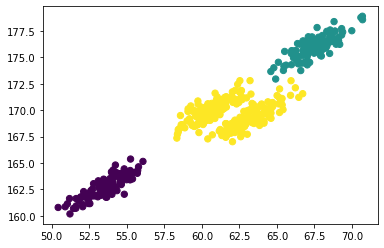

In [ ]:
labels = gm.predict (df)
plt.scatter (df[:, 0], df[:, 1], c = labels, s = 40, cmap='viridis')